An unsupervised kick clustering pipeline, using a deep audio embedding model (torchopenl3) and  clustering algorithms (HDBSCAN, k-means), which can automatically group hundreds of isolated hardstyle kicks into clusters. workflow processes raw .wav files, extracts robust embeddings for each kick, standardizes feature space, and visualizes/clusters kicks without any hand-tuned timbral rules.     


Input: Collections of isolated kick samples (.wav), from various hardstyle/hardcore sample packs.

Preprocessing: Each kick is trimmed, resampled, normalized, and converted to mono for consistent analysis.

Embedding: Audio is converted into deep feature vectors using torchopenl3, capturing important musical/timbral characteristics in an unsupervised way.

Standardization: Embeddings are scaled so features contribute evenly to analysis.

Clustering: HDBSCAN (and optionally k-means) groups kicks into clusters based on sound similarity and density, identifying outliers/noise.

Visualization: UMAP/PCA plots help you visually inspect and interpret timbral groupings.

Output: Cluster labels, per-kick filenames, and basic cluster summaries.

In [37]:
import os
import librosa
import numpy as np
import hdbscan
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import torchopenl3
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [36]:
# Embedding Extraction

def torchopenl3_embedding(path, sr=44100, window=1.0):
    y, orig_sr = librosa.load(path, sr=None, mono=True)
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)
    window_len = int(sr * window)
    if len(y) < window_len:
        y = np.pad(y, (0, window_len - len(y)))
    else:
        y = y[:window_len]
    emb, timestamps = torchopenl3.get_audio_embedding(
        y.astype('float32'),
        sr,
        content_type='music',
        embedding_size=512
    )
    # emb shape: (frames, features), so average over time (frames)
    emb = emb.mean(axis=0) if emb.ndim > 1 else emb
    return emb


In [31]:
# === 3. Build dataset of features from all kicks ===

# Root folder where kicks live (adjust path to your dataset)
kick_folder = Path('../data/kick_samples')
# Recursively collect all .wav file paths under kick_folder
kick_paths = [str(p) for p in kick_folder.rglob("*.wav")]

print(f"Found {len(kick_paths)} .wav files")
if len(kick_paths) > 0:
    print(f"First file: {kick_paths[0]}")
else:
    # Fail fast if no audio is found
    raise FileNotFoundError(f"No .wav files found in {kick_folder.absolute()}")

# Loop over all kicks, preprocess, then extract feature vector
embeddings = []
for p in kick_paths:
    emb = torchopenl3_embedding(p)
    # Protect against accidental frame dimension:
    if emb.ndim > 1:
        emb = emb.mean(axis=0)
    embeddings.append(emb)
embeddings = np.array(embeddings)


Found 734 .wav files
First file: ..\data\kick_samples\EW_SHK2_Climax_Kick_10_A#1.wav


c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\torchopenl3\models.py:200: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa.filters.mel(


In [9]:
help(torchopenl3.get_audio_embedding)


Help on function get_audio_embedding in module torchopenl3.core:

get_audio_embedding(audio, sr, model=None, input_repr='mel256', content_type='music', embedding_size=6144, center=True, hop_size=0.1, batch_size=32, verbose=True, weight_path='', sampler='resampy')



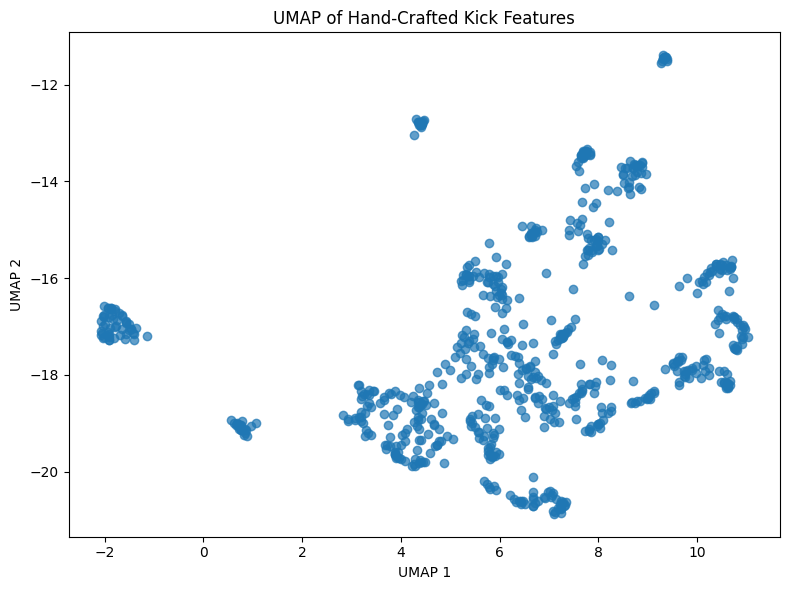

In [32]:
# === 4. Standardize features (global z-score) ===
# StandardScaler will subtract mean and divide by std for each feature dimension,
# so all features contribute more evenly to distance-based clustering.
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)


# === 5. UMAP for 2D visualization ===
# UMAP reduces the standardized feature space into 2D while preserving local structure,
# useful for visual inspection of potential clusters.
reducer = umap.UMAP(
    n_neighbors=15,   # how many neighbors to look at for local structure
    min_dist=0.1,     # how tightly points are packed in the low-dim space
    metric='euclidean'
)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7)
plt.title("UMAP of Hand-Crafted Kick Features")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mplx3\Documents\GitHub\meow\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


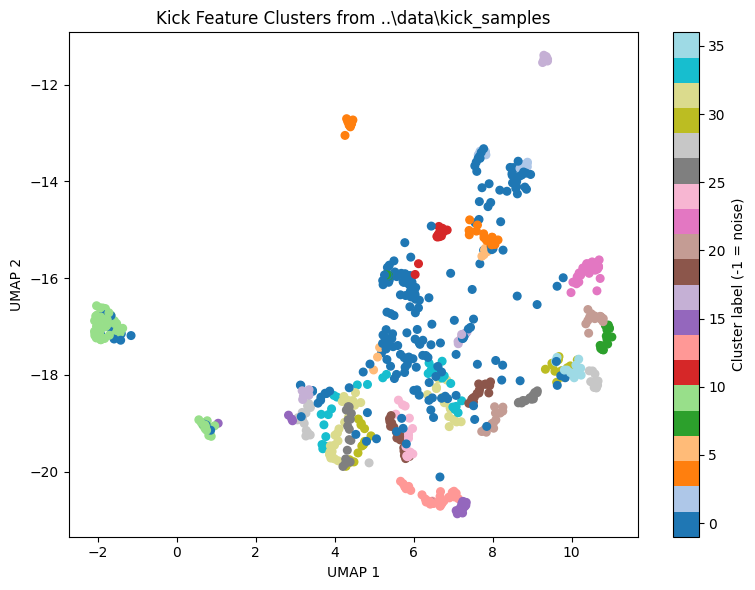

In [33]:
# === 6. Clustering with HDBSCAN on standardized features ===
# HDBSCAN will find dense regions in X (the standardized feature space) and
# assign each kick to a cluster label, or to -1 if considered noise/outlier. [web:32][web:38]
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,  # minimum size of a stable cluster (tune based on desired granularity) [web:32]
    min_samples=3,       # how conservative/outlier-sensitive the clustering is [web:32][web:38]
    metric='euclidean'
)
labels = clusterer.fit_predict(X)

# UMAP scatter colored by cluster label
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab20', s=30)
plt.title(f"Kick Feature Clusters from {kick_folder}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster label (-1 = noise)")
plt.tight_layout()
plt.show()


In [34]:
for cl in sorted(set(labels)):
    indices = np.where(labels == cl)[0]
    print(f"\nCluster {cl} - {len(indices)} samples")
    for idx in indices:
        print(f"  {kick_paths[idx]}")



Cluster -1 - 203 samples
  ..\data\kick_samples\EW_SHK2_Climax_Kick_21_A1.wav
  ..\data\kick_samples\EW_SHK2_Climax_Kick_21_B1.wav
  ..\data\kick_samples\EW_SHK2_Climax_Kick_21_E2.wav
  ..\data\kick_samples\EW_SHK2_Climax_Kick_24_D1.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_10_A.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_11_F#.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_12_G#_T.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_13_D#_T.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_14_A.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_15_F.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_17_G#.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_18_F.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_19_F#.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_1_A.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_20_A.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_21_Rumble.wav
  ..\data\kick_samples\EW_SHK2_Mid_Intro_Kick_23_A.wav
  ..\data\kick_samples\EW_SHK2_Mid

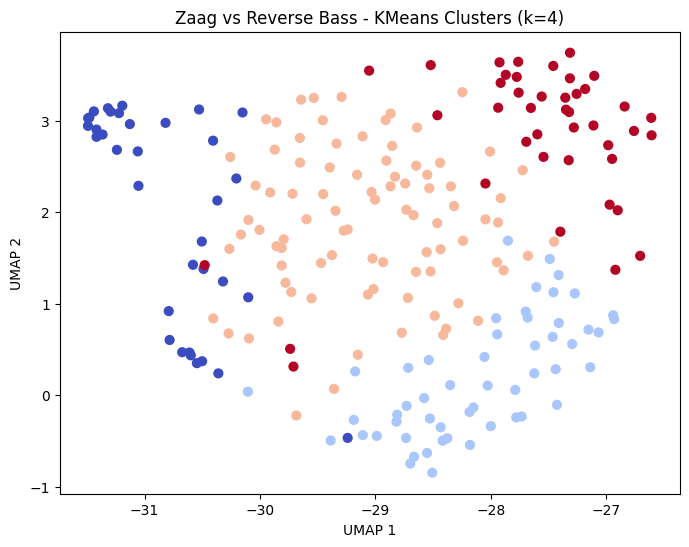

In [30]:
from sklearn.cluster import KMeans

cluster_count = 4

# X: standardized features, as before
kmeans = KMeans(n_clusters=cluster_count, n_init=10, random_state=42)
km_labels = kmeans.fit_predict(X)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=km_labels, cmap='coolwarm', s=40)
plt.title(f"Zaag vs Reverse Bass - KMeans Clusters (k={cluster_count})")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.show()
        



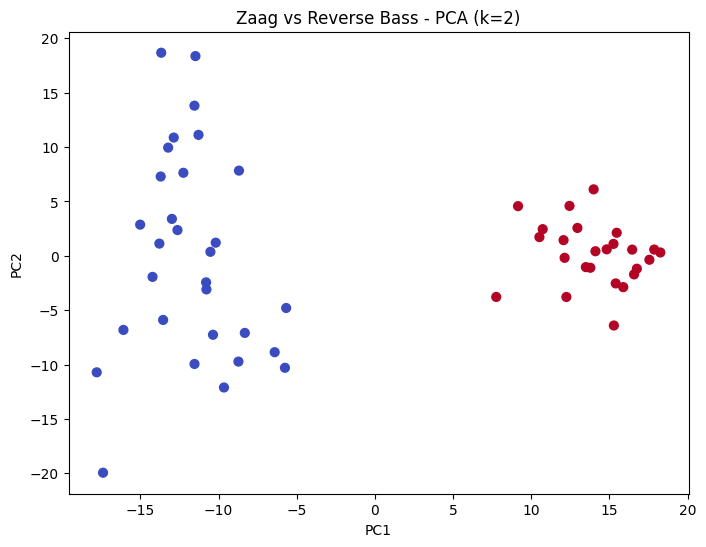

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=km_labels, cmap='coolwarm', s=40)
plt.title("Zaag vs Reverse Bass - PCA (k=2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()
